In [1]:
import numpy as np
from datetime import datetime, timedelta
import glob
import mne
import re
import pandas as pd 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') #living on the edge (but i really hate warnings)

In [2]:
#Gather all resting state recordings
#this takes a while due to some 10khz recordings
BASE_PATH = '/mnt/sinuhe/data_raw/**/**/**/*.fif'

files = glob.glob(BASE_PATH)
files = [file for file in files if 'rest' in file or 'Rest' in file or 'REST' in file]

subject_ids = []
measurement_age = []
measurement_date = []
measurement_age_days = []
clean_path = []
fs_1k = []

for file in files:
    f_split = file.split('/')
    cur_id = f_split[-1].lower()[:12]
        
    if re.match("\d{8}[a-z]{4}", cur_id) and 'sss' not in f_split[-1]: #only take proper ids for now

        cur_data = mne.io.read_raw_fif(file, verbose=False, allow_maxshield=True)
        if cur_data.info['sfreq'] == 1000: #only take 1kHz recordings for now
            fs_1k.append(True)
        else:
            fs_1k.append(False)
        subject_ids.append(cur_id)
        recording_date = datetime.strptime(f_split[-2], '%y%m%d')
        try:
            birth_date = datetime.strptime(f_split[-1][:8], '%Y%m%d') #in ~2 cases dates are formatted weird
        except ValueError:
            pass
        
        measurement_age.append((recording_date - birth_date) // timedelta(days=365.2425))
        measurement_age_days.append((recording_date - birth_date).days)
        measurement_date.append(recording_date)
        clean_path.append(file)
        
        
df = pd.DataFrame({'subject_id': np.array(subject_ids),
                   'measurement_age': np.array(measurement_age),
                   'measurement_age_days': np.array(measurement_age_days),
                   'measurement_date': np.array(measurement_date),
                   'path': np.array(clean_path),
                   'fs_1k': np.array(fs_1k)})

df = df[df['measurement_age'] < 100] #remove methusalem
df

,subject_id,measurement_age,measurement_age_days,measurement_date,path,fs_1k
1,19800616mrgu,36,13429,2017-03-23,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
2,19851130eifi,31,11436,2017-03-23,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
3,19901026krke,26,9646,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
4,19950604llzm,21,7964,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
5,19961118brsh,20,7431,2017-03-24,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
...,...,...,...,...,...,...
1974,19991028mchi,22,8275,2022-06-24,/mnt/sinuhe/data_raw/nsss_crossmodmarkov/subje...,True
1975,19940510dota,28,10282,2022-07-04,/mnt/sinuhe/data_raw/nsss_crossmodmarkov/subje...,True
1976,20010219lddt,21,7806,2022-07-05,/mnt/sinuhe/data_raw/nsss_crossmodmarkov/subje...,True
1977,19651225jsjs,56,20647,2022-07-06,/mnt/sinuhe/data_raw/nsss_crossmodmarkov/subje...,True


In [3]:
df.to_csv('./data/resting_lists_sbg/resting_list.csv')

In [4]:
df_unique = df.drop_duplicates(subset='subject_id', keep='last')
df_unique.to_csv('./data/resting_lists_sbg/resting_list_single.csv')

(array([645., 773., 211., 116.,  29.,  57.,  61.,  68.,  14.,   4.]),
 array([18. , 23.9, 29.8, 35.7, 41.6, 47.5, 53.4, 59.3, 65.2, 71.1, 77. ]),
 <BarContainer object of 10 artists>)

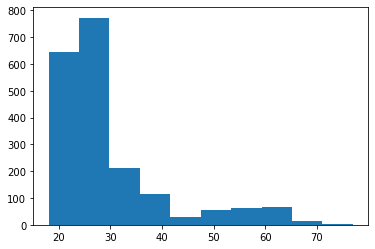

In [5]:
plt.hist(df['measurement_age'])

In [35]:
#Get subject ids with multiple recordings
df_1k = df[df['fs_1k']]
ids, counts = np.unique(df_1k['subject_id'], return_counts=True)
id_list = ids[counts > 4]

df_multi = df_1k.query('subject_id in @id_list')
df_multi.reset_index(inplace=True)
df_multi.drop(columns='index', inplace=True)
df_multi.to_csv('./data/resting_lists_sbg/resting_list_multi.csv')

df_multi

,subject_id,measurement_age,measurement_age_days,measurement_date,path,fs_1k
0,19800616mrgu,36,13429,2017-03-23,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
1,19810726gdzn,35,13141,2017-07-18,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
2,19870319wlgl,31,11390,2018-05-25,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
3,19800616mrgu,38,13987,2018-10-02,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
4,19940430slbc,24,8921,2018-10-02,/mnt/sinuhe/data_raw/gd_markov/subject_subject...,True
...,...,...,...,...,...,...
528,19910612crke,30,11213,2022-02-22,/mnt/sinuhe/data_raw/nsss_crossmodmarkov/subje...,True
529,19680529eidx,53,19684,2022-04-20,/mnt/sinuhe/data_raw/nsss_crossmodmarkov/subje...,True
530,19800616mrgu,41,15283,2022-04-20,/mnt/sinuhe/data_raw/nsss_crossmodmarkov/subje...,True
531,19910811sbsu,30,11217,2022-04-27,/mnt/sinuhe/data_raw/nsss_crossmodmarkov/subje...,True


In [36]:
rep_ids = ids[counts > 4]
reps = counts[counts > 4]

In [63]:
age_dist = []

for subject in rep_ids:
    cur_df = df_multi.query(f'subject_id == "{subject}"')
    age_dist.append(cur_df['measurement_age'].max() - cur_df['measurement_age'].min())

rep_ids[np.array(age_dist) > 0]

(array([19.,  0.,  7.,  0.,  5.,  0.,  9.,  0.,  7.,  3.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

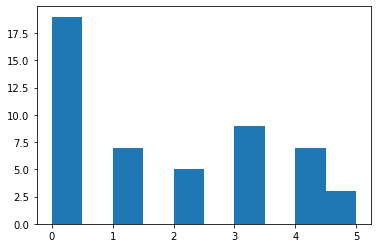

In [64]:
plt.hist(age_dist)

In [71]:
rep_ids[np.array(age_dist) > 0].shape

(31,)

<BarContainer object of 50 artists>

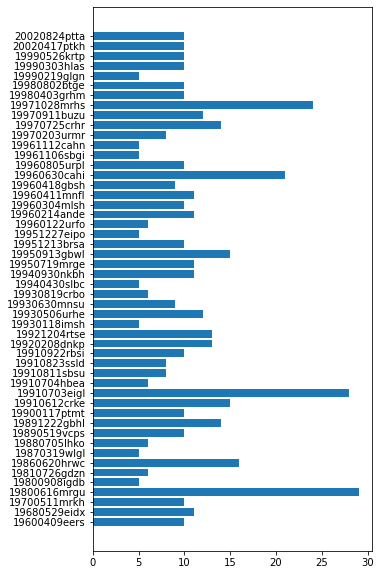

In [56]:
plt.figure(figsize=(5,10))
plt.barh(y=rep_ids, width=reps)